In [1]:
from skimage.transform import pyramid_reduce, resize,warp
from skimage import color,img_as_float32
import cv2
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from scipy import ndimage as ndi
import flow_vis

D:\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [145]:
def resize_flow_vectors(u, v, lvl):
    r, c = u.shape
    u = resize(u, lvl.shape, order=0, preserve_range=True,anti_aliasing=False)
    v = resize(v, lvl.shape, order=0, preserve_range=True,anti_aliasing=False)
    scaled_y, scaled_x = lvl.shape[0]/r, lvl.shape[1]/c
    resized_u, resized_v = scaled_x*u, scaled_y*v
    return resized_u, resized_v

In [214]:
def pyramid_(img_base, pyr_lvl, min_size):
    pyramid_struct = [img_base]
    img_size = min(img_base.shape[0],img_base.shape[1])
    for i in range(1,pyr_lvl):
        if img_size > min_size:
            lvl = pyramid_reduce(pyramid_struct[-1], downscale=2.0)
            pyramid_struct.append(lvl)
            img_size = min(lvl.shape[0],lvl.shape[1])
    return pyramid_struct[::-1]

In [215]:
def coarse2fine(frame0, frame1, solver, pyr_lvl=10, min_size=16):

    if frame0.ndim == 3:
        frame0 = color.rgb2gray(frame0)
    if frame1.ndim == 3:
        frame1 = color.rgb2gray(frame1)
    if frame0.shape != frame1.shape:
        print ("Input images should have the same shape")
        exit()

    pyramid_f0 = pyramid_(img_as_float32(frame0),pyr_lvl, min_size)
    pyramid_f1 = pyramid_(img_as_float32(frame1),pyr_lvl, min_size)
    pyramid = list(zip(pyramid_f0, pyramid_f1))

    u, v = np.zeros_like(pyramid[0][0]), np.zeros_like(pyramid[0][0])
    u, v = solver(pyramid[0][0], pyramid[0][1], u, v)
    for lvl_prev, lvl_nex in pyramid[1:]:
        u, v = resize_flow_vectors(u, v, lvl_prev)
        u, v = solver(lvl_prev, lvl_nex, u, v)
    return u, v

In [216]:
def optical_flow_interpolation_error(frame0, frame1, flow):
    flow_c = flow.copy()
    h = flow.shape[0]
    w = flow.shape[1]
    flow_c *= -1
    flow_c[:,:,0] += np.arange(w)
    flow_c[:,:,1] += np.arange(h)[:,np.newaxis]
    interpolated_frame = cv2.remap(frame0.astype(np.float32), flow_c.astype(np.float32), None, cv2.INTER_LINEAR)
    mse = np.square(np.subtract(frame1.astype(np.float32),interpolated_frame)).mean()
    return mse, interpolated_frame

In [222]:
def lucaskanade_main(frame0, frame1, u0, v0, rad, nwarp):
    
    r, c = frame0.shape
    y, x = np.mgrid[:r, :c]
    sigma_val = (2*rad+1)/4
    u,v = u0.copy(),v0.copy()
    for i in range(nwarp):
        warp_f1 = warp(frame1, np.array([y+v, x+u]), mode='constant', order=0)
        Iy, Ix = np.gradient(warp_f1)
        It = warp_f1 - frame0 - u*Ix - v*Iy
        Ixx = Ix*Ix
        Ixy = Ix*Iy
        Iyy = Iy*Iy
        Ixt = Ix*It
        Iyt = Iy*It
        Ixx = ndi.gaussian_filter(Ixx, sigma=sigma_val, mode='mirror')
        Ixy = ndi.gaussian_filter(Ixy, sigma=sigma_val, mode='mirror')
        Iyy = ndi.gaussian_filter(Iyy, sigma=sigma_val, mode='mirror')
        Ixt = ndi.gaussian_filter(Ixt, sigma=sigma_val, mode='mirror')
        Iyt = ndi.gaussian_filter(Iyt, sigma=sigma_val, mode='mirror')
        detA = -(Ixx*Iyy - Ixy*Ixy)
        idx = abs(detA) < 1e-14
        detA[idx] = 1
        u = (Ixt*Iyy - Ixy*Iyt)/detA
        v = (Iyt*Ixx - Ixy*Ixt)/detA
        u[idx] = 0
        v[idx] = 0
    return u, v

In [223]:
def call_lucas_kanade(frame0, frame1, rad=7, nwarp=10):
    solver = partial(lucaskanade_main, rad=rad, nwarp=nwarp)
    return coarse2fine(frame0, frame1, solver)

In [224]:
def visualize_flow_arrows(u, v, frame1):
    n, m = u.shape
    u_deci = u[np.ix_(range(0, n, 5), range(0, m, 5))]
    v_deci = v[np.ix_(range(0, n, 5), range(0, m, 5))]
    [X,Y] = np.meshgrid(np.arange(m, dtype = 'float32'), np.arange(n, dtype = 'float32'))
    X_deci = X[np.ix_(range(0, n, 5), range(0, m, 5))]
    Y_deci = Y[np.ix_(range(0, n, 5), range(0, m, 5))]
    u_deci = u[np.ix_(range(0, n, 5), range(0, m, 5))]
    v_deci = v[np.ix_(range(0, n, 5), range(0, m, 5))]
    plt.figure(figsize=(15,15))
    plt.imshow(frame1,cmap='gray')
    plt.quiver(X_deci, Y_deci, u_deci, v_deci)
    plt.title('flow vectors')
    plt.show()

In [225]:
plt.style.use('default')

prev_frame_urban="C:/Users/viswa/OneDrive/Desktop/eval-color-twoframes (1)/eval-data/Urban/frame10.png"
curr_frame_urban="C:/Users/viswa/OneDrive/Desktop/eval-color-twoframes (1)/eval-data/Urban/frame11.png"

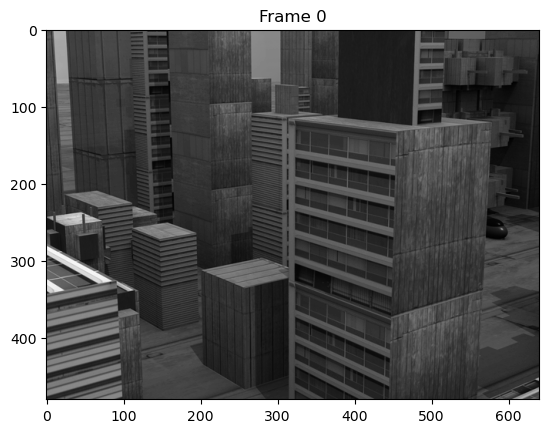

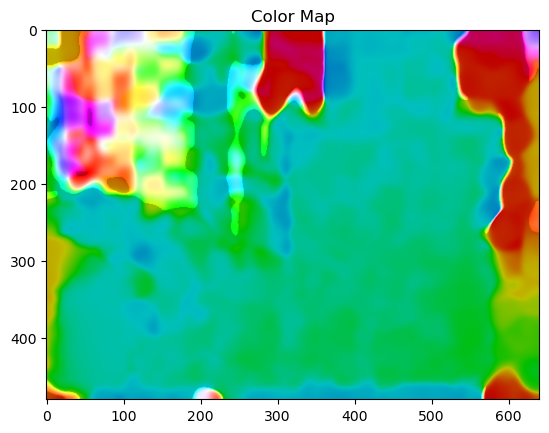

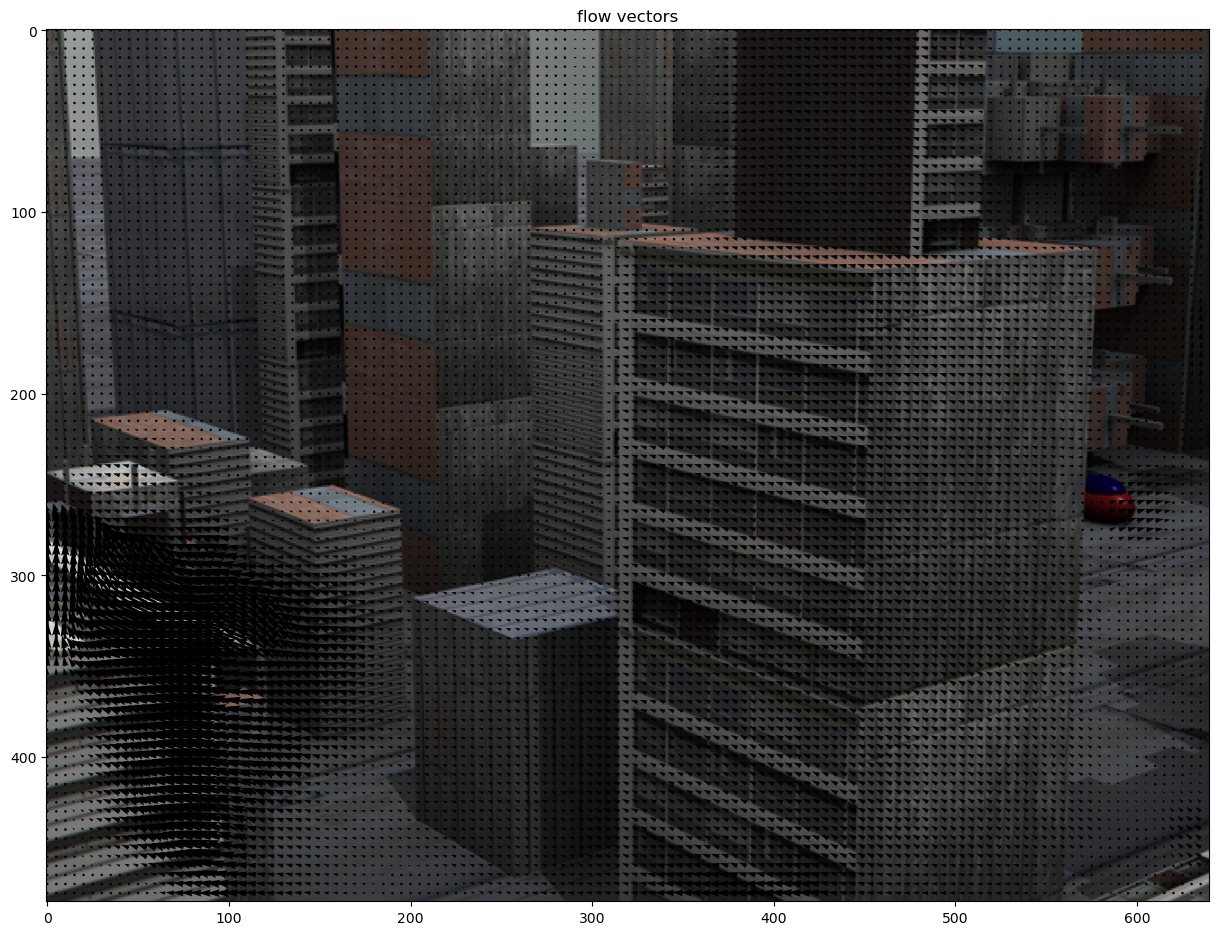

Interpolation Error (MSE):  89.16502


In [226]:
prev_frame_urban=cv2.imread(prev_frame_urban)
prev_frame_gray_urban=cv2.cvtColor(prev_frame_urban,cv2.COLOR_BGR2GRAY)
prev_frame_rgb_urban = cv2.cvtColor(prev_frame_urban, cv2.COLOR_BGR2RGB)
curr_frame_urban=cv2.imread(curr_frame_urban)
curr_frame_gray_urban=cv2.cvtColor(curr_frame_urban,cv2.COLOR_BGR2GRAY)
curr_frame_rgb_urban = cv2.cvtColor(curr_frame_urban, cv2.COLOR_BGR2RGB)
plt.imshow(prev_frame_gray_urban,cmap='gray')
plt.title('Frame 0')
plt.show()

u_urban, v_urban = call_lucas_kanade(prev_frame_gray_urban, curr_frame_gray_urban, rad=14)
pl_urban = flow_vis.flow_uv_to_colors(u_urban, v_urban)
plt.imshow(pl_urban)
plt.title('Color Map')
plt.show()
visualize_flow_arrows(u_urban, v_urban, prev_frame_rgb_urban)
plt.show()
mse_urban, new_frame_urban = optical_flow_interpolation_error(prev_frame_gray_urban, curr_frame_gray_urban, np.stack((u_urban,v_urban), axis=-1)
)
print("Interpolation Error (MSE): ", mse_urban)


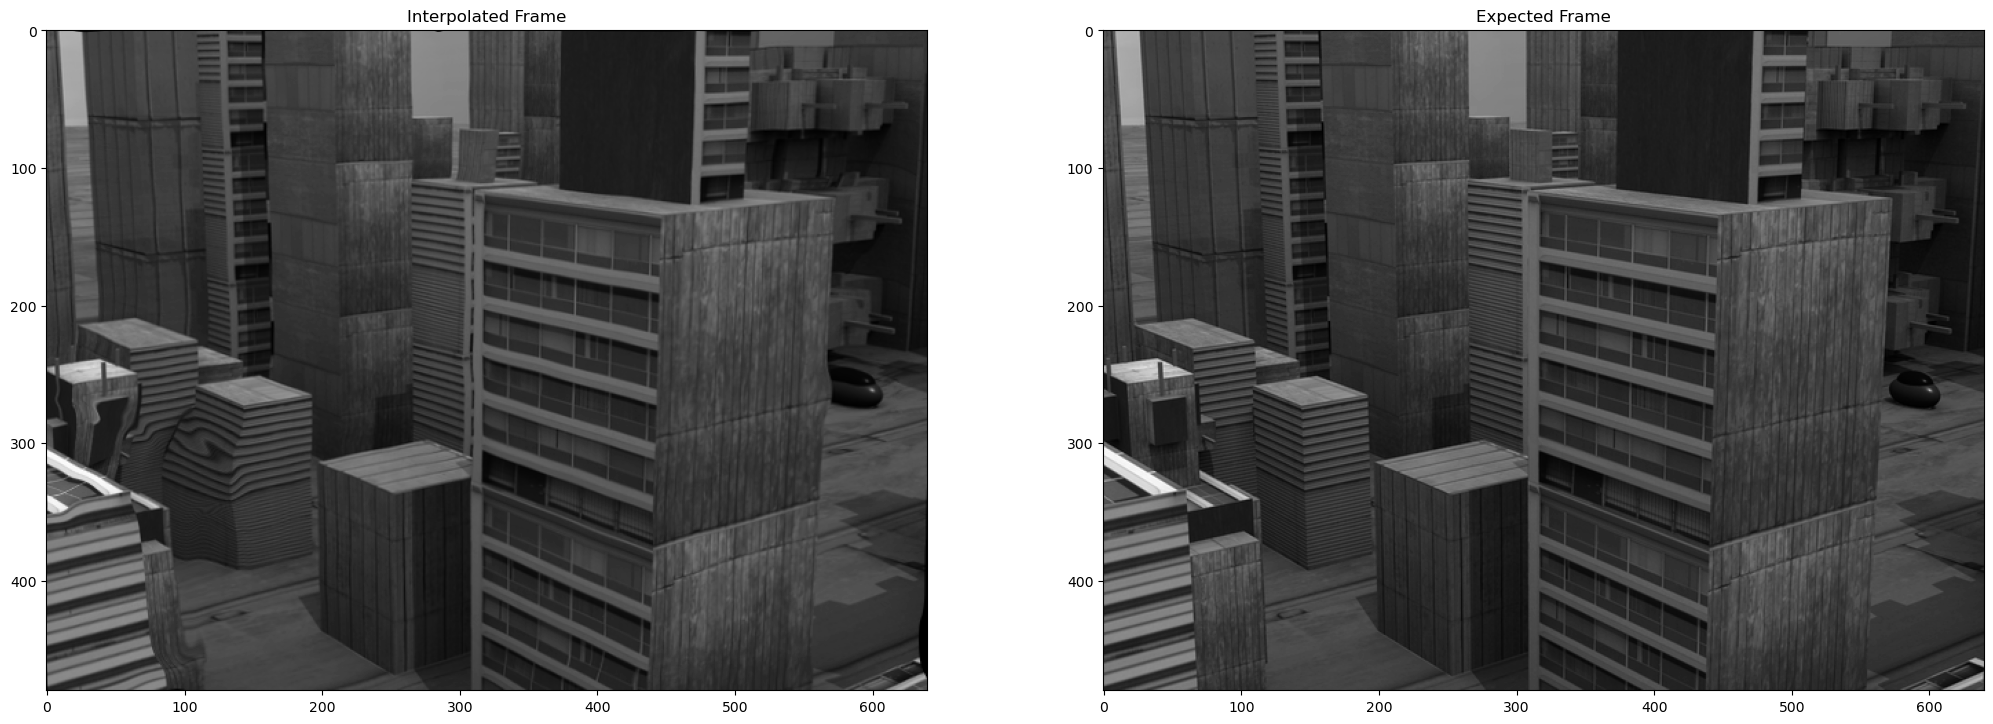

In [227]:
fig = plt.figure(figsize= (25, 25))
plt.subplot(1,2,1)
plt.imshow(new_frame_urban,cmap='gray')
plt.title('Interpolated Frame')
plt.subplot(1,2,2)
plt.imshow(curr_frame_gray_urban,cmap='gray')
plt.title('Expected Frame')
plt.show()

[126.210495, 114.15076, 95.87094, 96.743095, 98.825264, 93.288246, 91.97315, 90.8971, 91.81141, 96.400276, 89.16502, 100.30564]


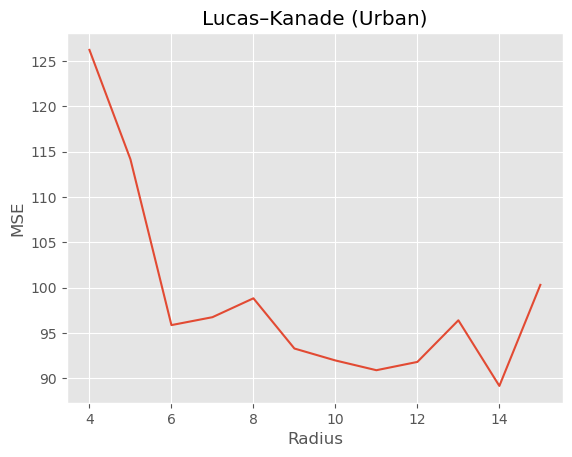

In [228]:
plt.style.use('ggplot')
radii = np.arange(4,16, 1)
mse_r_urban = []
for r in radii:
    u, v = call_lucas_kanade(prev_frame_gray_urban, curr_frame_gray_urban, rad=r)
    # Assuming you have predicted_flow, prev_frame, and current_frame loaded
    flow = np.stack((u,v), axis=-1)
    mse,_ = optical_flow_interpolation_error(prev_frame_gray_urban, curr_frame_gray_urban, flow)
    mse_r_urban.append(mse)
plt.plot(radii, mse_r_urban)
plt.title("Lucas–Kanade (Urban)")
plt.xlabel("Radius")
plt.ylabel("MSE")
print(mse_r_urban)

In [229]:
prev_frame_army="C:/Users/viswa/OneDrive/Desktop/eval-color-twoframes (1)/eval-data/Army/frame10.png"
curr_frame_army="C:/Users/viswa/OneDrive/Desktop/eval-color-twoframes (1)/eval-data/Army/frame11.png"

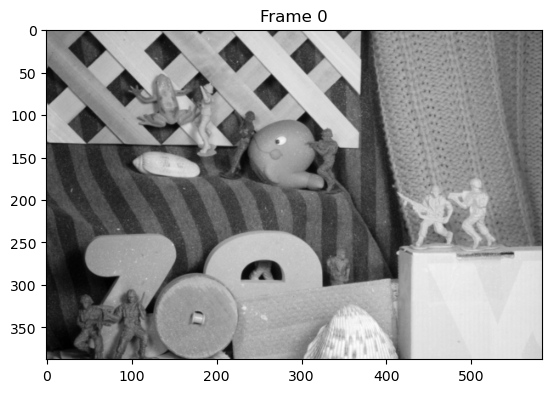

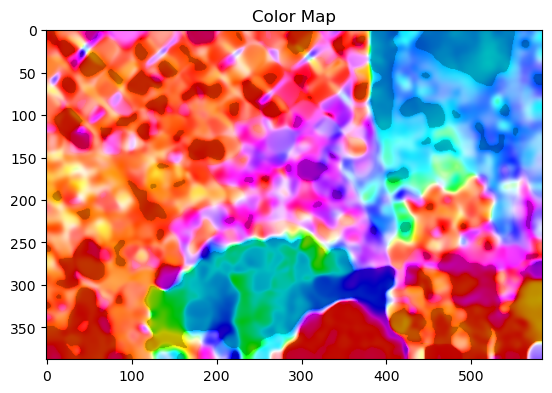

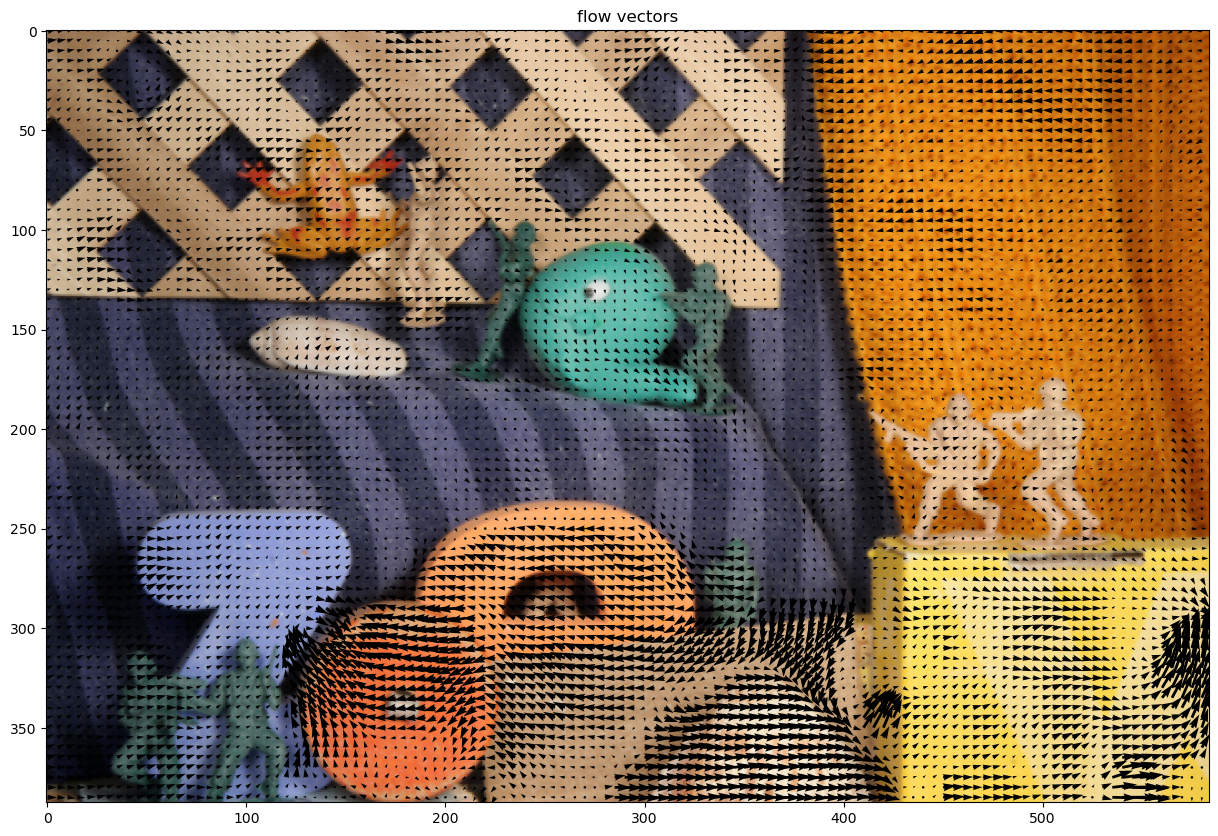

Interpolation Error (MSE):  33.154125
33.154125


In [230]:
plt.style.use('default')
prev_frame_army=cv2.imread(prev_frame_army)
prev_frame_gray_army=cv2.cvtColor(prev_frame_army,cv2.COLOR_BGR2GRAY)
prev_frame_rgb_army = cv2.cvtColor(prev_frame_army, cv2.COLOR_BGR2RGB)
curr_frame_army=cv2.imread(curr_frame_army)
curr_frame_gray_army=cv2.cvtColor(curr_frame_army,cv2.COLOR_BGR2GRAY)
curr_frame_rgb_army = cv2.cvtColor(curr_frame_army, cv2.COLOR_BGR2RGB)
plt.imshow(prev_frame_gray_army,cmap='gray')
plt.title('Frame 0')
plt.show()

u_army, v_army = call_lucas_kanade(prev_frame_gray_army, curr_frame_gray_army,rad=8)
pl_army = flow_vis.flow_uv_to_colors(u_army, v_army)
plt.imshow(pl_army)
plt.title('Color Map')
plt.show()
visualize_flow_arrows(u_army, v_army, prev_frame_rgb_army)
plt.show()
mse_army, new_frame_army = optical_flow_interpolation_error(prev_frame_gray_army, curr_frame_gray_army, np.stack((u_army,v_army), axis=-1)
)
print("Interpolation Error (MSE): ", mse_army)
print(mse_army)

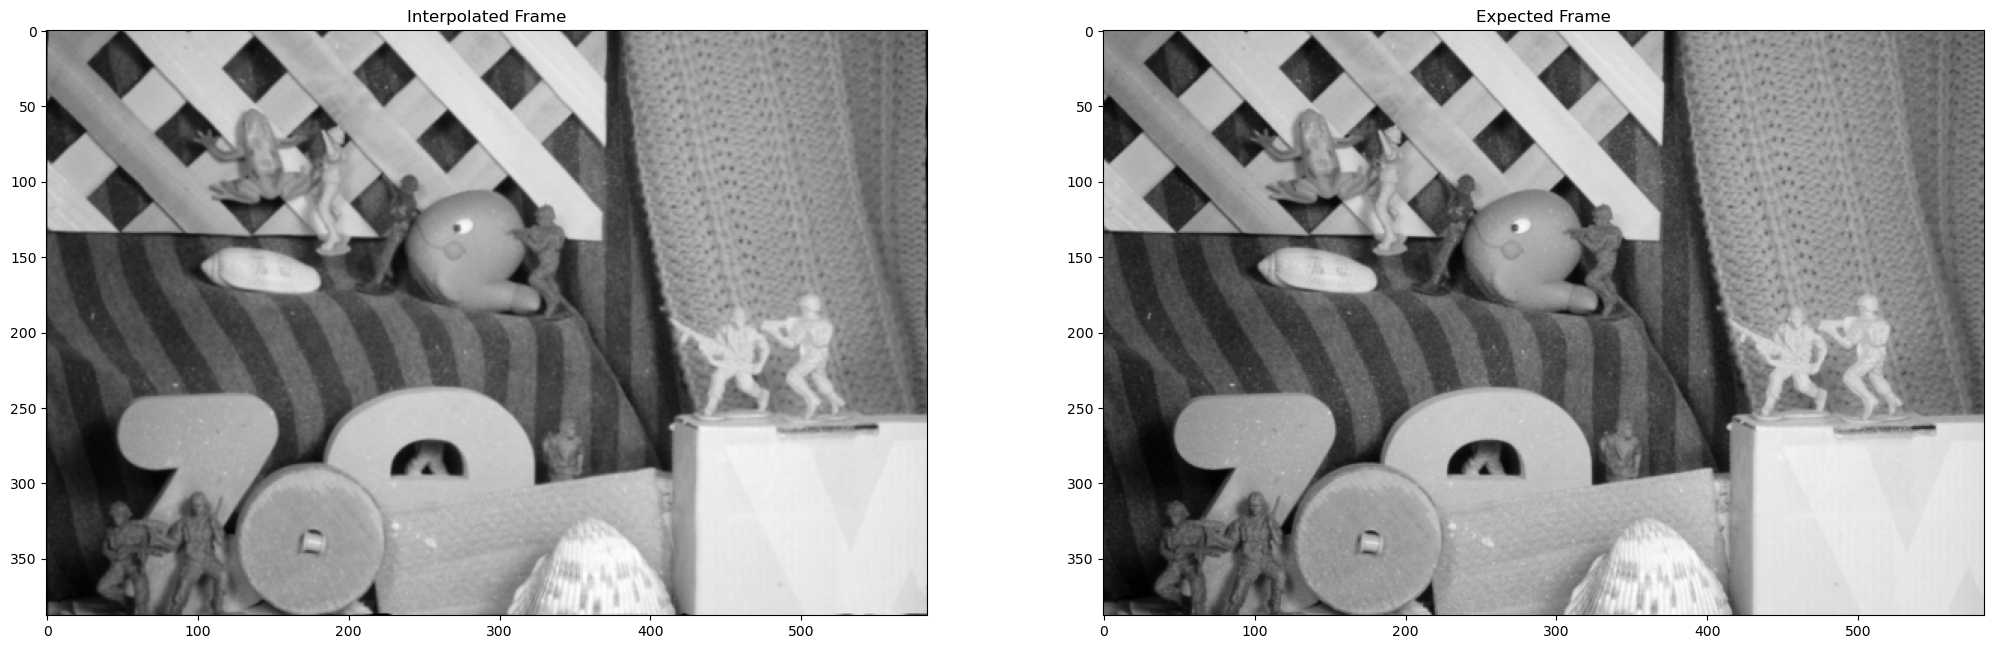

In [231]:
fig = plt.figure(figsize= (25, 25))
plt.subplot(1,2,1)
plt.imshow(new_frame_army,cmap='gray')
plt.title('Interpolated Frame')
plt.subplot(1,2,2)
plt.imshow(curr_frame_gray_army,cmap='gray')
plt.title('Expected Frame')
plt.show()

Text(0, 0.5, 'MSE')

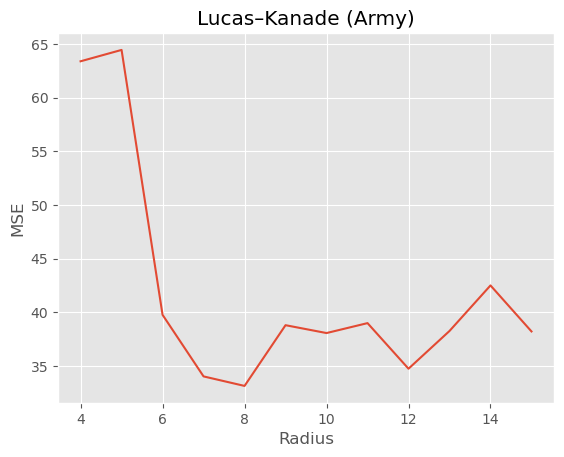

In [236]:
plt.style.use('ggplot')
radii = np.arange(4,16, 1)
mse_r_army = []
for r in radii:
    u, v = call_lucas_kanade(prev_frame_gray_army, curr_frame_gray_army, rad=r)
    # Assuming you have predicted_flow, prev_frame, and current_frame loaded
    flow = np.stack((u,v), axis=-1)
    mse,_ = optical_flow_interpolation_error(prev_frame_gray_army, curr_frame_gray_army, flow)
    mse_r_army.append(mse)
plt.plot(radii, mse_r_army)
plt.title("Lucas–Kanade (Army)")
plt.xlabel("Radius")
plt.ylabel("MSE")

In [233]:
prev_frame_Mequon="C:/Users/viswa/OneDrive/Desktop/eval-color-twoframes (1)/eval-data/Mequon/frame10.png"
curr_frame_Mequon="C:/Users/viswa/OneDrive/Desktop/eval-color-twoframes (1)/eval-data/Mequon/frame11.png"

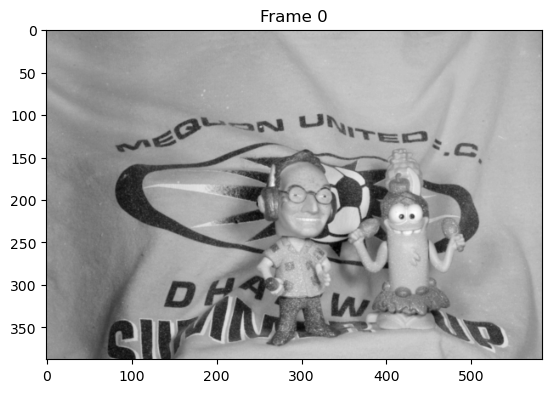

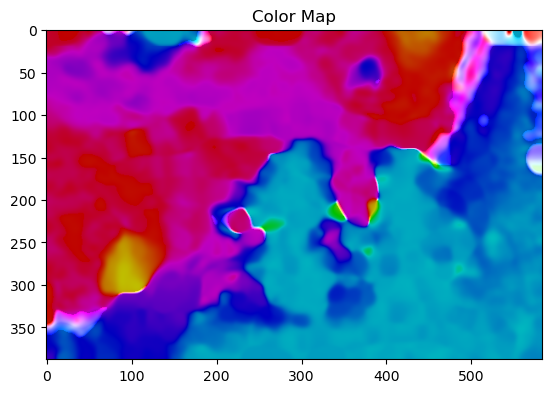

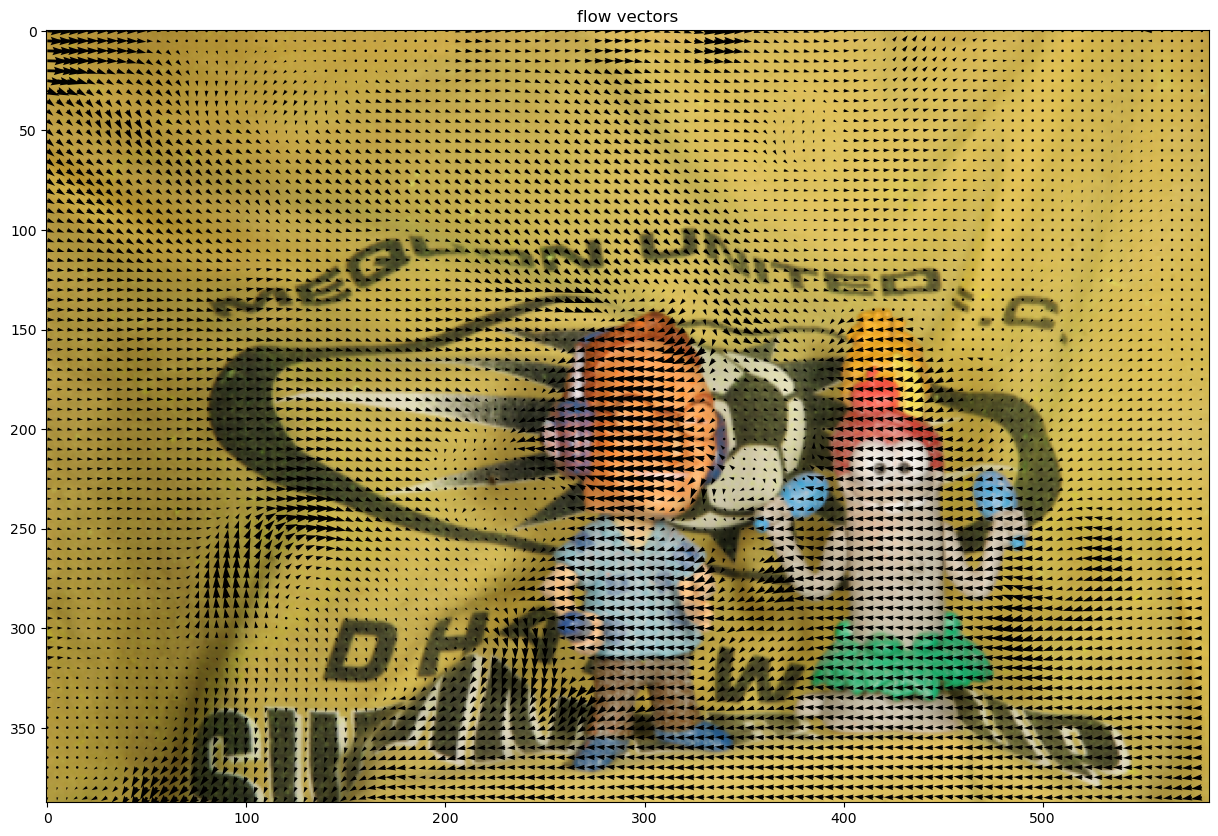

Interpolation Error (MSE):  364.1431


In [234]:
plt.style.use('default')
prev_frame_Mequon=cv2.imread(prev_frame_Mequon)
prev_frame_gray_Mequon=cv2.cvtColor(prev_frame_Mequon,cv2.COLOR_BGR2GRAY)
prev_frame_rgb_Mequon = cv2.cvtColor(prev_frame_Mequon, cv2.COLOR_BGR2RGB)
curr_frame_Mequon=cv2.imread(curr_frame_Mequon)
curr_frame_gray_Mequon=cv2.cvtColor(curr_frame_Mequon,cv2.COLOR_BGR2GRAY)
curr_frame_rgb_Mequon = cv2.cvtColor(curr_frame_Mequon, cv2.COLOR_BGR2RGB)
plt.imshow(prev_frame_gray_Mequon,cmap='gray')
plt.title('Frame 0')
plt.show()

u_Mequon, v_Mequon = call_lucas_kanade(prev_frame_gray_Mequon,curr_frame_gray_Mequon,rad=9)
pl_Mequon = flow_vis.flow_uv_to_colors(u_Mequon, v_Mequon)
plt.imshow(pl_Mequon)
plt.title('Color Map')
plt.show()
visualize_flow_arrows(u_Mequon, v_Mequon, prev_frame_rgb_Mequon)
plt.show()
mse, new_frame_Mequon = optical_flow_interpolation_error(prev_frame_gray_Mequon, curr_frame_gray_Mequon, np.stack((u_Mequon,v_Mequon), axis=-1)
)
print("Interpolation Error (MSE): ", mse)


Text(0, 0.5, 'MSE')

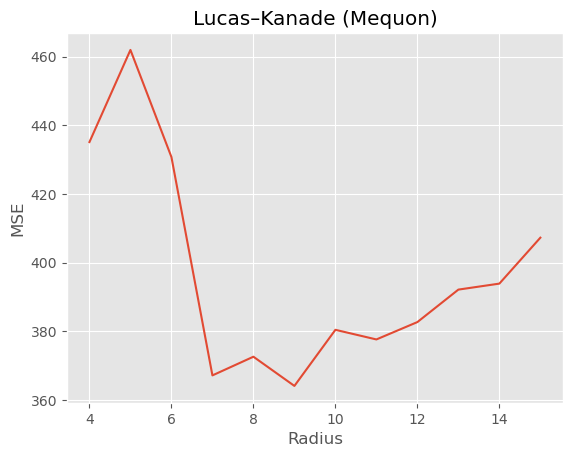

In [237]:
plt.style.use('ggplot')
mse_r_Mequon = []
for r in radii:
    u, v = call_lucas_kanade(prev_frame_gray_Mequon, curr_frame_gray_Mequon, rad=r)
    # Assuming you have predicted_flow, prev_frame, and current_frame loaded
    flow = np.stack((u,v), axis=-1)
    mse,_ = optical_flow_interpolation_error(prev_frame_gray_Mequon, curr_frame_gray_Mequon, flow)
    mse_r_Mequon.append(mse)
plt.plot(radii, mse_r_Mequon)
plt.title("Lucas–Kanade (Mequon)")
plt.xlabel("Radius")
plt.ylabel("MSE")